In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycircstat2.distributions as pcd

from pycircstat2 import Circular, load_data
from pycircstat2.clustering import MovM, MoKJ, MoCD, CircHAC, CircKMeans


# Clustering circular data

We implemented 3 clustering algorithms for circular data: 

- Mixture of von Mises
- Circular hierarchical agglomerative clustering
- Circular k-means

Here, we use dataset B3 from Fisher (1993) to demonstrate the their usages, as it is also the example shown in Jammalamadaka & Vaidyanathan (2024).

In [2]:
d = load_data("B3", source="fisher")["θ"].values[:]


hac = CircHAC(n_clusters=2, unit="degree", random_seed=2046, metric="chord")
hac.fit(d)

ckm = CircKMeans(n_clusters=2, unit="degree", random_seed=2046, metric="chord")
ckm.fit(d)

movm = MovM(n_clusters=2, unit="degree", random_seed=2046)
movm.fit(d)

mocd = MoCD(distribution=pcd.cardioid, n_clusters=2, unit="degree", random_seed=2046)
mocd.fit(d)

mocw = MoCD(distribution=pcd.cartwright, n_clusters=2, unit="degree", random_seed=2046)
mocw.fit(d)

mown = MoCD(distribution=pcd.wrapnorm, n_clusters=2, unit="degree", random_seed=2046)
mown.fit(d)

mowc = MoCD(distribution=pcd.wrapcauchy, n_clusters=2, unit="degree", random_seed=2046)
mowc.fit(d)

mokj = MoKJ(n_clusters=2, unit="degree", random_seed=2046)
mokj.fit(d)


In [3]:
# Extract values
μ_movm = np.rad2deg(movm.m_).round(4)[:][::-1]
κ_movm = movm.kappa_.round(4)[::-1]
p_movm = movm.p_.round(4)[::-1]

μ_hac = np.rad2deg(hac.centers_).round(4)[::-1]
p_hac = np.bincount(hac.labels_) / len(hac.labels_)  # Estimate p as relative cluster size
p_hac = np.round(p_hac, 4)[::-1]

μ_ckm = np.rad2deg(ckm.centers_).round(4)
p_ckm = np.bincount(ckm.labels_) / len(ckm.labels_)  # Estimate p for KMeans
p_ckm = np.round(p_ckm, 4)

# Paper values (Jammalamadaka & Vaidyanathan, 2024)
μ_paper = [63.4716, 241.2036]
κ_paper = [2.6187, 8.4465]
p_paper = [0.84, 0.16]

# Construct the table
df = pd.DataFrame({
    "Method": ["Paper (J&V 2024)", "MovM", "CircHAC", "CircKMeans"],
    "μ1 (deg)": [μ_paper[0], μ_movm[0], μ_hac[0], μ_ckm[0]],
    "μ2 (deg)": [μ_paper[1], μ_movm[1], μ_hac[1], μ_ckm[1]],
    "κ1": [κ_paper[0], κ_movm[0], "N/A", "N/A"],
    "κ2": [κ_paper[1], κ_movm[1], "N/A", "N/A"],
    "p1": [p_paper[0], p_movm[0], p_hac[0], p_ckm[0]],
    "p2": [p_paper[1], p_movm[1], p_hac[1], p_ckm[1]]
})

df

,Method,μ1 (deg),μ2 (deg),κ1,κ2,p1,p2
0,Paper (J&V 2024),63.4716,241.2036,2.6187,8.4465,0.8400,0.1600
1,MovM,63.4706,241.1973,2.609,8.4559,0.8367,0.1633
2,CircHAC,63.5275,241.5256,N/A,N/A,0.8289,0.1711
3,CircKMeans,64.6328,246.0378,N/A,N/A,0.8158,0.1842


Text(0.5, 1.0, 'CircKMeans cluster 2')

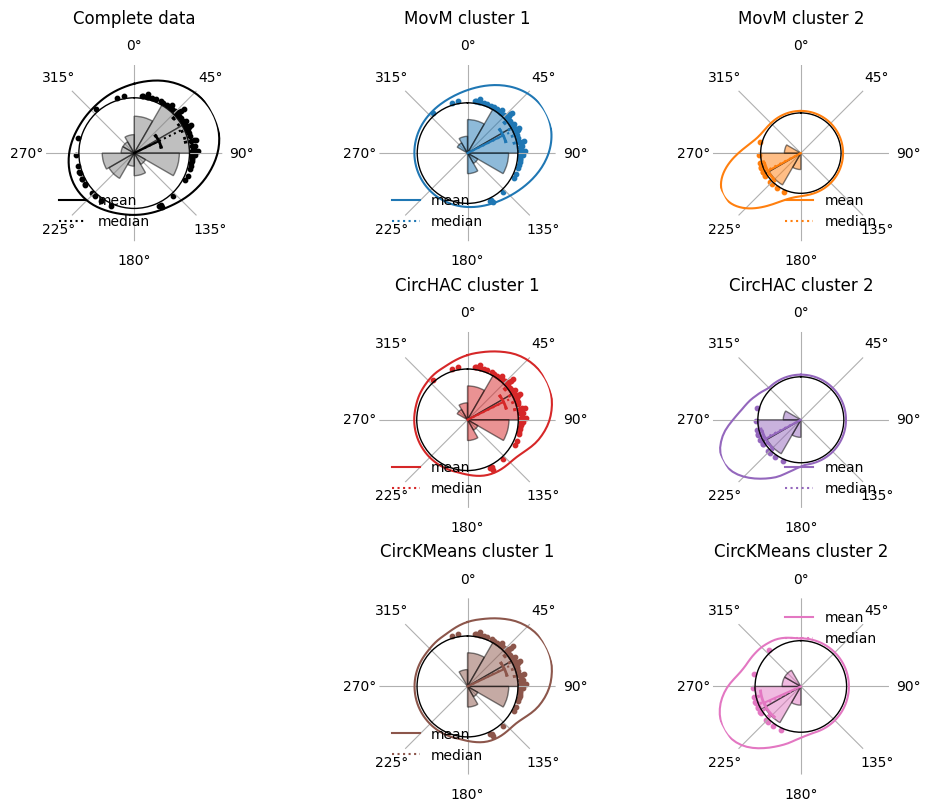

In [4]:
ax_labels = ["A", "B", "C", "D", "E", "F", "G"]
fig, ax = plt.subplot_mosaic(
    mosaic="""
    ABC
    .DE
    .FG
    """, figsize=(10, 8), 
    subplot_kw={"projection": "polar"},
    layout="constrained",
)

# complete data
c = Circular(d)
c.plot(ax=ax["A"])

theta_grid = np.linspace(0, 2 * np.pi, 200, endpoint=False)
movm_component_offsets = {}
for k in range(movm.n_clusters):
    pdf_k = pcd.vonmises.pdf(theta_grid, mu=movm.m_[k], kappa=movm.kappa_[k])
    # Optional: multiply by movm.p_[k] if you want the height to reflect mixture weights.
    movm_component_offsets[k] = np.sqrt(1.0 + np.pi * pdf_k) - 1.0

for i, k in enumerate([1, 0]):
    x_k = movm.data[movm.labels_ == k]
    c_k = Circular(data=x_k, unit=movm.unit)

    c_k.plot(
        ax=ax[ax_labels[i + 1]],
        config={
            "density": {
                "color": f"C{i}",
                "x": theta_grid,
                "f": movm_component_offsets[k],
            },
            "scatter": {"color": f"C{i}"},
            "mean": {"color": f"C{i}"},
            "median": {"color": f"C{i}"},
            "rose": {"color": f"C{i}"},
        },
    )

for i, k in enumerate([1, 0]):
    
    # clustered data    
    x_k = hac.data[hac.labels_ == k]
    c_k = Circular(data=x_k, unit=hac.unit)

    j = i + 3
    c_k.plot(
        ax=ax[ax_labels[j]], 
        config={
            "density": {"color": f"C{j}"},
            "scatter": {"color": f"C{j}"},
            "mean": {"color": f"C{j}"},
            "median": {"color": f"C{j}"},
            "rose": {"color": f"C{j}"},
        }
    )

for i, k in enumerate([0, 1]):
    
    # clustered data    
    x_k = ckm.data[ckm.labels_ == k]
    c_k = Circular(data=x_k, unit=ckm.unit)

    j = i + 5
    c_k.plot(
        ax=ax[ax_labels[j]], 
        config={
            "density": {"color": f"C{j}"},
            "scatter": {"color": f"C{j}"},
            "mean": {"color": f"C{j}"},
            "median": {"color": f"C{j}"},
            "rose": {"color": f"C{j}"},
        }
    )
    
ax["A"].set_title("Complete data", pad=30)
ax["B"].set_title("MovM cluster 1", pad=30)
ax["C"].set_title("MovM cluster 2", pad=30)
ax["D"].set_title("CircHAC cluster 1", pad=30)
ax["E"].set_title("CircHAC cluster 2", pad=30)
ax["F"].set_title("CircKMeans cluster 1", pad=30)
ax["G"].set_title("CircKMeans cluster 2", pad=30)

`MovM` is actually already built into the `Circular` class as an exploratory tool. By setting `n_clusters_max` when initializing the `Circular` data object, `MovM` will run `n_clusters_max` times, from 1 to `n_clusters_max`, and select the model with the lowest BIC as the optimal number of clusters.

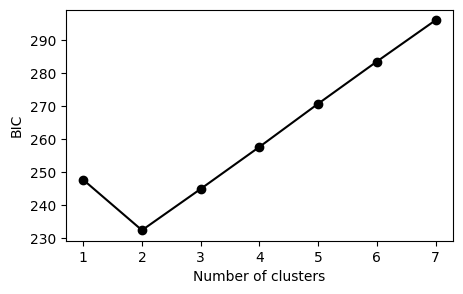

In [5]:
c = Circular(d, n_clusters_max=7)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(range(1, 8), c.mixtures_BIC, marker="o", c="black")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
plt.show()

In the dataset summary, the clustering result will be displayed on the second line (Unimodal?):

In [6]:
print(c.summary())

Circular Data

Summary
-------
  Grouped?: No
  Unimodal?: No (n_clusters=2) 
  Unit: degree
  Sample size: 76
  Angular mean: 64.17 ( p=0.0000 *** ) 
  Angular mean CI (0.95): 50.85 - 77.49
  Angular median: 64.00 
  Angular median CI (0.95): 48.00 - 78.00
  Angular deviation (s): 57.46 
  Circular standard deviation (s0): 67.74 
  Concentration (r): 0.50
  Concentration (kappa): 1.14
  Skewness: -0.082
  Kurtosis: 1.657

Signif. codes:
--------------
 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Method
------
  Angular median: deviation
  Angular mean CI: dispersion



In [7]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-11-03 12:50:42CET

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 9.6.0

pycircstat2: 0.1.15
pandas     : 2.3.3
matplotlib : 3.10.7
numpy      : 2.3.4

Watermark: 2.5.0



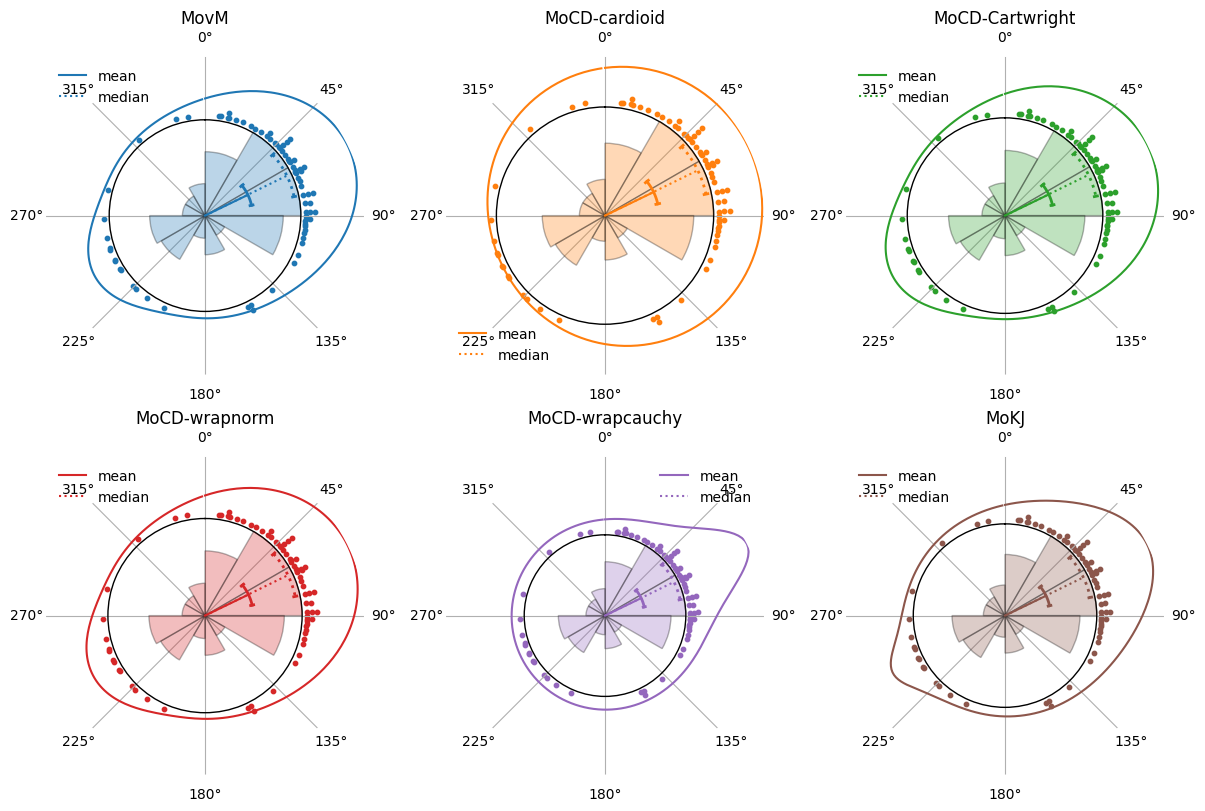

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pycircstat2.base import Circular

theta = np.linspace(0, 2 * np.pi, 256, endpoint=False)

def density_offsets(model, theta):
    pdf = model.predict_density(theta, unit="radian")
    return np.sqrt(1.0 + np.pi * pdf) - 1.0

def model_panel(ax, circular_obj, model, color, title):
    circular_obj.plot(
        ax=ax,
        config={
            "density": {"color": color, "x": theta, "f": density_offsets(model, theta)},
            "scatter": {"color": color, "alpha": 0.4},
            "rose": {"color": color, "alpha": 0.3},
            "mean": {"color": color},
            "median": {"color": color},
        },
    )
    ax.set_title(title, pad=24)

models = [
    ("MovM", movm),
    ("MoCD-cardioid", mocd),
    ("MoCD-Cartwright", mocw),
    ("MoCD-wrapnorm", mown),
    ("MoCD-wrapcauchy", mowc),
    ("MoKJ", mokj),
]

circ = Circular(d, unit="degree")
fig, axes = plt.subplots(2, 3, figsize=(12, 8), subplot_kw={"projection": "polar"}, layout="constrained")

for ax, (label, model), color in zip(axes.flat, models, plt.rcParams["axes.prop_cycle"].by_key()["color"]):
    model_panel(ax, circ, model, color, label)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pycircstat2.base import Circular
from pycircstat2.clustering import MovM, MoCD, MoKJ
from pycircstat2.distributions import vonmises, katojones

theta = np.linspace(0.0, 2.0 * np.pi, 360, endpoint=False)

def pdf_to_offset(pdf):
    return np.sqrt(1.0 + np.pi * pdf) - 1.0  # matches circ_plot’s radial transform

def lighten(color, amount=0.35):
    r, g, b = mcolors.to_rgb(color)
    return tuple(1.0 - (1.0 - c) * (1.0 - amount) for c in (r, g, b))

def darken(color, amount=0.25):
    r, g, b = mcolors.to_rgb(color)
    return tuple(c * (1.0 - amount) for c in (r, g, b))

def component_offsets(model, grid):
    if isinstance(model, MovM):
        comps = zip(model.p_, model.m_, model.kappa_)
        return {i: pdf_to_offset(w * vonmises.pdf(grid, mu=mu, kappa=kappa))
                for i, (w, mu, kappa) in enumerate(comps)}
    if isinstance(model, MoCD):
        return {i: pdf_to_offset(model.p_[i] *
                model.distribution.pdf(grid, **model.params_[i]))
                for i in range(model.n_clusters)}
    if isinstance(model, MoKJ):
        comps = zip(model.p_, model.mu_, model.gamma_, model.rho_, model.lam_)
        return {i: pdf_to_offset(w * katojones.pdf(grid, mu=mu, gamma=gamma,
                                                    rho=rho, lam=lam))
                for i, (w, mu, gamma, rho, lam) in enumerate(comps)}
    raise TypeError(f"Unsupported model type: {type(model)!r}")

def plot_model_clusters(ax_row, model, label, base_color):
    offsets = component_offsets(model, theta)
    palette = [lighten(base_color, 0.45), darken(base_color, 0.25)]
    for cluster_id, ax in enumerate(np.atleast_1d(ax_row)):
        mask = model.labels_ == cluster_id
        if not np.any(mask):
            ax.set_axis_off()
            continue
        color = palette[min(cluster_id, len(palette)-1)]
        circ = Circular(model.data[mask], unit=model.unit)
        circ.plot(
            ax=ax,
            config={
                "density": {"color": color, "x": theta, "f": offsets[cluster_id], "linestyle": "-"},
                "scatter": {"color": color, "alpha": 0.65},
                "rose": {"color": color, "alpha": 0.35, "edgecolor": darken(color, 0.3)},
                "mean": {"color": color},
                "median": {"color": color},
            },
        )
        ax.set_title(f"{label} · Cluster {cluster_id + 1}", pad=20)

models = [
    ("MovM", movm),
    ("MoCD – cardioid", mocd),
    ("MoCD – Cartwright", mocw),
    ("MoCD – wrapnorm", mown),
    ("MoCD – wrapcauchy", mowc),
    ("MoKJ", mokj),
]

base_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
n_models = len(models)

fig = plt.figure(figsize=(11, 2.8 * n_models), constrained_layout=False)
gs = fig.add_gridspec(n_models, 2, wspace=0.04, hspace=0.35)

axes = []
for r in range(n_models):
    row_axes = []
    for c in range(2):
        ax = fig.add_subplot(gs[r, c], projection="polar")
        row_axes.append(ax)
    axes.append(row_axes)

for row, (label, model) in enumerate(models):
    plot_model_clusters(axes[row], model, label, base_cycle[row % len(base_cycle)])

plt.show()

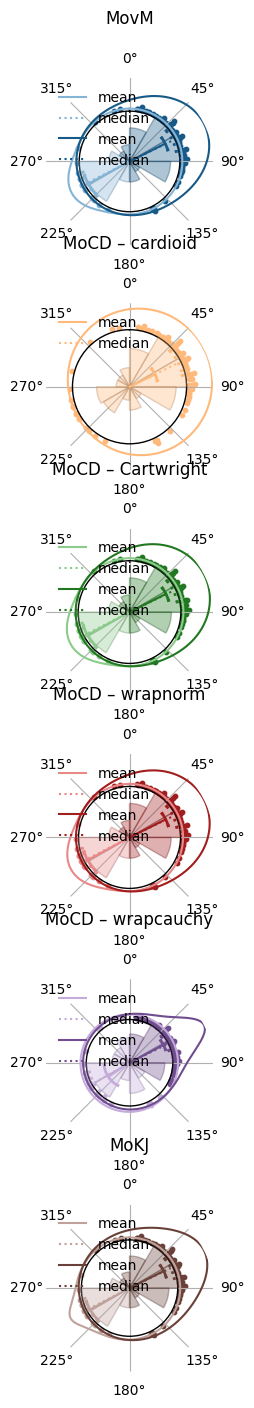

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from pycircstat2.base import Circular
from pycircstat2.clustering import MovM, MoCD, MoKJ
from pycircstat2.distributions import vonmises, katojones

theta = np.linspace(0.0, 2.0 * np.pi, 360, endpoint=False)

def pdf_to_offset(pdf):
    return np.sqrt(1.0 + np.pi * pdf) - 1.0  # matches circ_plot’s radial transform

def lighten(color, amount=0.35):
    r, g, b = mcolors.to_rgb(color)
    return tuple(1.0 - (1.0 - c) * (1.0 - amount) for c in (r, g, b))

def darken(color, amount=0.25):
    r, g, b = mcolors.to_rgb(color)
    return tuple(c * (1.0 - amount) for c in (r, g, b))

def component_offsets(model, grid):
    if isinstance(model, MovM):
        comps = zip(model.p_, model.m_, model.kappa_)
        return {
            i: pdf_to_offset(w * vonmises.pdf(grid, mu=mu, kappa=kappa))
            for i, (w, mu, kappa) in enumerate(comps)
        }
    if isinstance(model, MoCD):
        return {
            i: pdf_to_offset(model.p_[i] * model.distribution.pdf(grid, **model.params_[i]))
            for i in range(model.n_clusters)
        }
    if isinstance(model, MoKJ):
        comps = zip(model.p_, model.mu_, model.gamma_, model.rho_, model.lam_)
        return {
            i: pdf_to_offset(w * katojones.pdf(grid, mu=mu, gamma=gamma, rho=rho, lam=lam))
            for i, (w, mu, gamma, rho, lam) in enumerate(comps)
        }
    raise TypeError(f"Unsupported model type: {type(model)!r}")

def plot_model_overlay(ax, model, label, base_color):
    """Draw all clusters of `model` on a single polar axis, preserving colors."""
    offsets = component_offsets(model, theta)
    palette = {0: lighten(base_color, 0.45), 1: darken(base_color, 0.25)}  # same as before

    # Assume two clusters; fall back to 2 if attribute missing.
    for cluster_id in range(getattr(model, "n_clusters", 2)):
        if cluster_id not in offsets:
            continue
        mask = (model.labels_ == cluster_id)
        if not np.any(mask):
            continue

        color = palette.get(cluster_id, palette[1])  # extra clusters use the dark variant
        circ = Circular(model.data[mask], unit=model.unit)
        circ.plot(
            ax=ax,
            config={
                "density": {"color": color, "x": theta, "f": offsets[cluster_id], "linestyle": "-"},
                "scatter": {"color": color, "alpha": 0.65},
                "rose": {"color": color, "alpha": 0.35, "edgecolor": darken(color, 0.3)},
                "mean": {"color": color},
                "median": {"color": color},
                "legend": False,
            },
        )

    ax.set_title(label, pad=20)

# --- figure layout: one subplot per model, both clusters overlaid ---
models = [
    ("MovM", movm),
    ("MoCD – cardioid", mocd),
    ("MoCD – Cartwright", mocw),
    ("MoCD – wrapnorm", mown),
    ("MoCD – wrapcauchy", mowc),
    ("MoKJ", mokj),
]

base_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
n_models = len(models)

fig = plt.figure(figsize=(6.5, 2.8 * n_models), constrained_layout=False)
gs = fig.add_gridspec(n_models, 1, wspace=0.04, hspace=0.35)

axes = [fig.add_subplot(gs[r, 0], projection="polar") for r in range(n_models)]

for row, (label, model) in enumerate(models):
    plot_model_overlay(axes[row], model, label, base_cycle[row % len(base_cycle)])

plt.show()
